In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
sys.path.append(os.path.abspath(".."))
from utils import read_features, read_targets, metrics_c, update_scoreboard, plot_compare_feature_scores, print_info_features, run_cv_all, scale_all, reduce_all, add_all_feature_combos, encode_labels, load_best_params

## Read Features and Targets

In [4]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/chronology_prediction"))

In [5]:
X = read_features(path)
y = read_targets(path, ["HistoricalPeriod"])

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


## Extra Preprocessing

### Scale Features

In [6]:
X = scale_all(X)

### Reduce Features

Use n_components=0.95 to keep enough components to preserve 95% of the variance in the data.

In [7]:
X_reduced = reduce_all(X, n_components=0.95)

### Combine & Re-scale Text & Image Feature Sets

In [8]:
X = add_all_feature_combos(X, scale=True)

X_reduced = add_all_feature_combos(X_reduced, scale=True)

### Final Feature Sets

In [9]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 300), 
		bert: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
		cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2917), 
		resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2048), 
		vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
		tfidf + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 3217), 
		tfidf + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2348), 
		tfidf + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 1068), 
		bert + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 3685), 
		bert + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2816), 
		bert + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 1536), 
	},
	test: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 300), 
		bert

In [10]:
print_info_features(X_reduced)

{
	train: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 300), 
		bert: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 225), 
		cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 190), 
		resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 262), 
		vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 177), 
		tfidf + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 490), 
		tfidf + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 562), 
		tfidf + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 477), 
		bert + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 415), 
		bert + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 487), 
		bert + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 402), 
	},
	test: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 300), 
		bert: 
			<c

### Encode Target Labels

In [11]:
y, target_enc, le = encode_labels(y, "HistoricalPeriod")

0 --> Archaic
1 --> Classical
2 --> Hellenistic
3 --> Orientalizing


## Load Best Parameters from HP Tuning

In [12]:
path_params = "best_params.json"
best_params = load_best_params(path_params)

## Initialize 10-Fold Cross Validation


In [13]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds = list(skf.split(np.arange(y["train"].shape[0]), y["train"]["HistoricalPeriod_encoded"]))

## Initialize Scoreboard

In [14]:
scoreboard = pd.DataFrame(columns=["model", "target", "features"] + list(metrics_c.keys()))
scoreboard

,model,target,features,accuracy,precision,recall,f1


## Logistic Regression

Cross Validation Score Progression


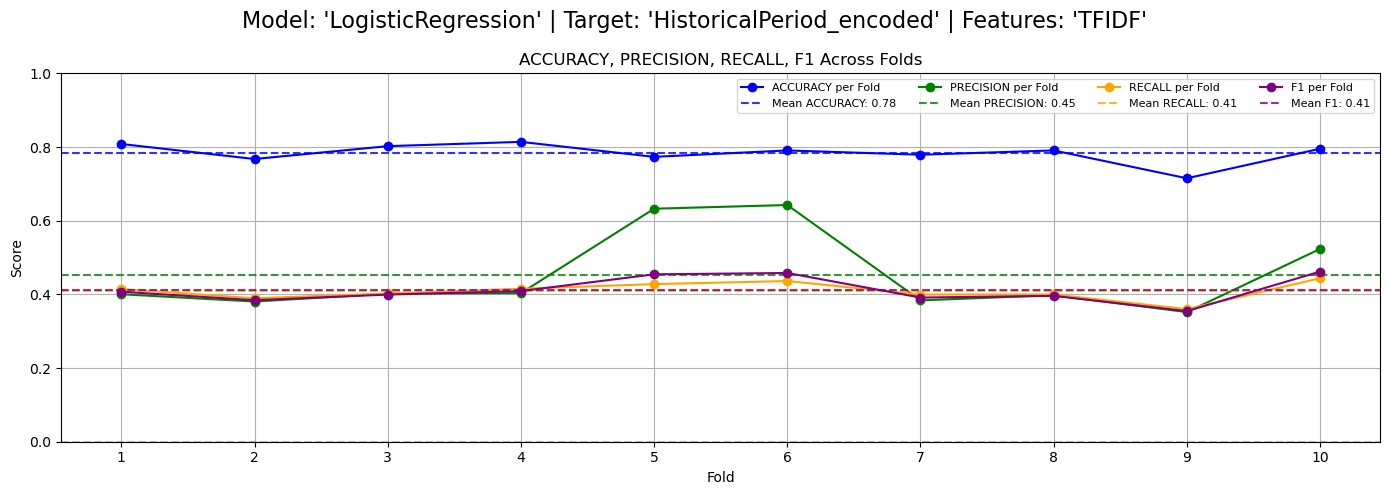

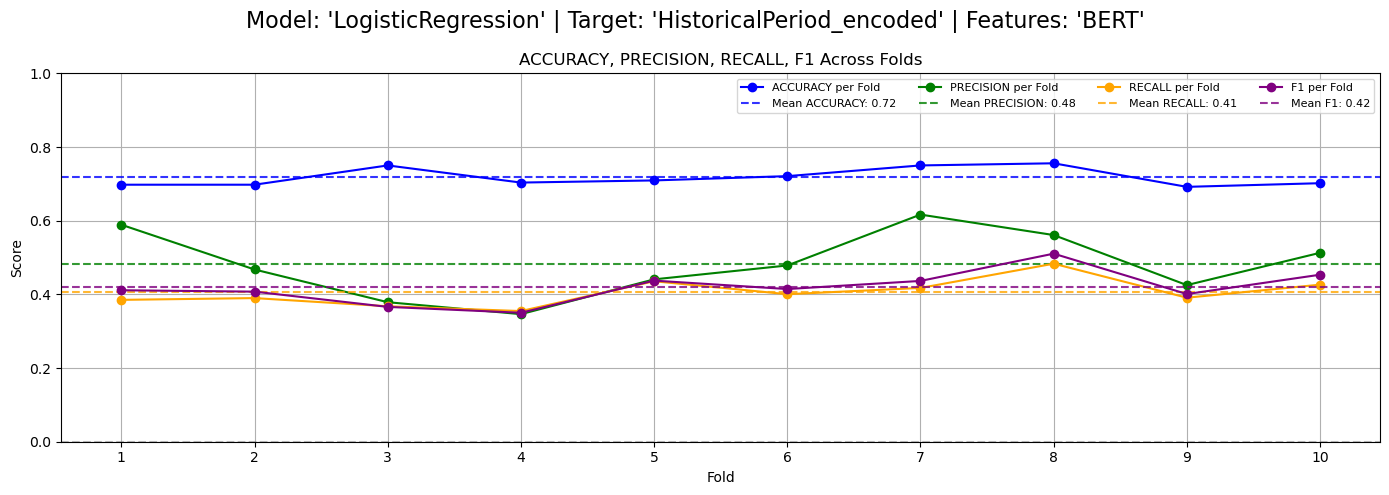

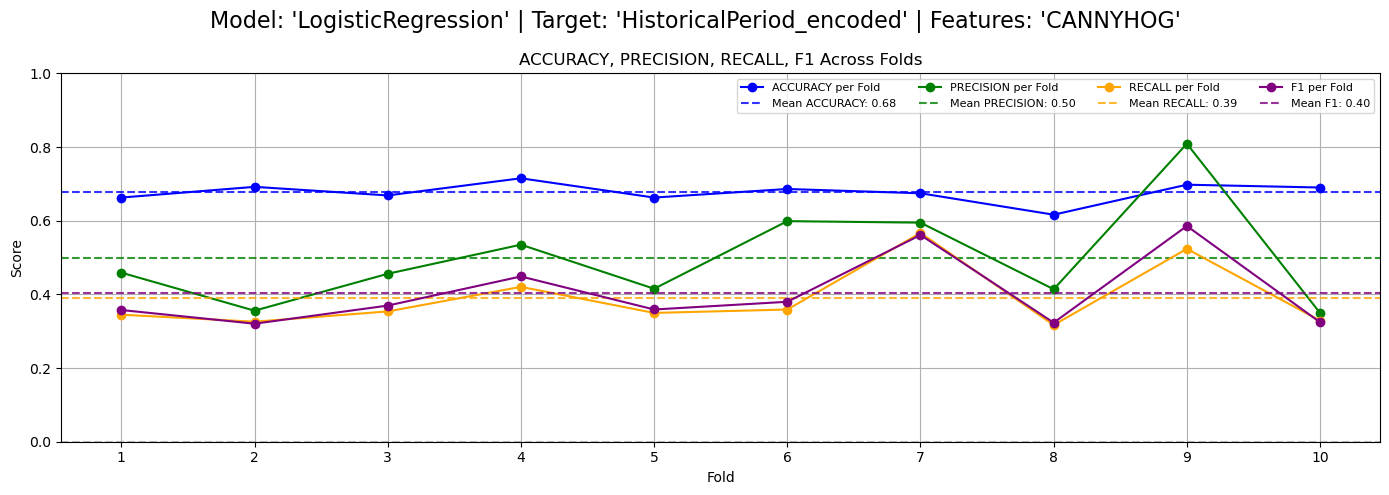

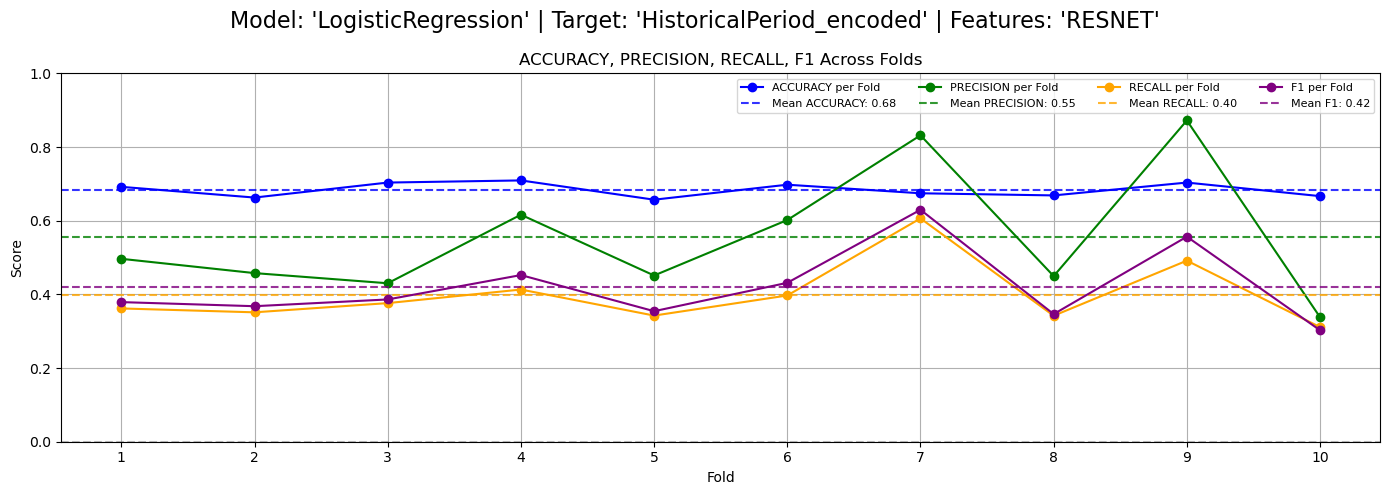

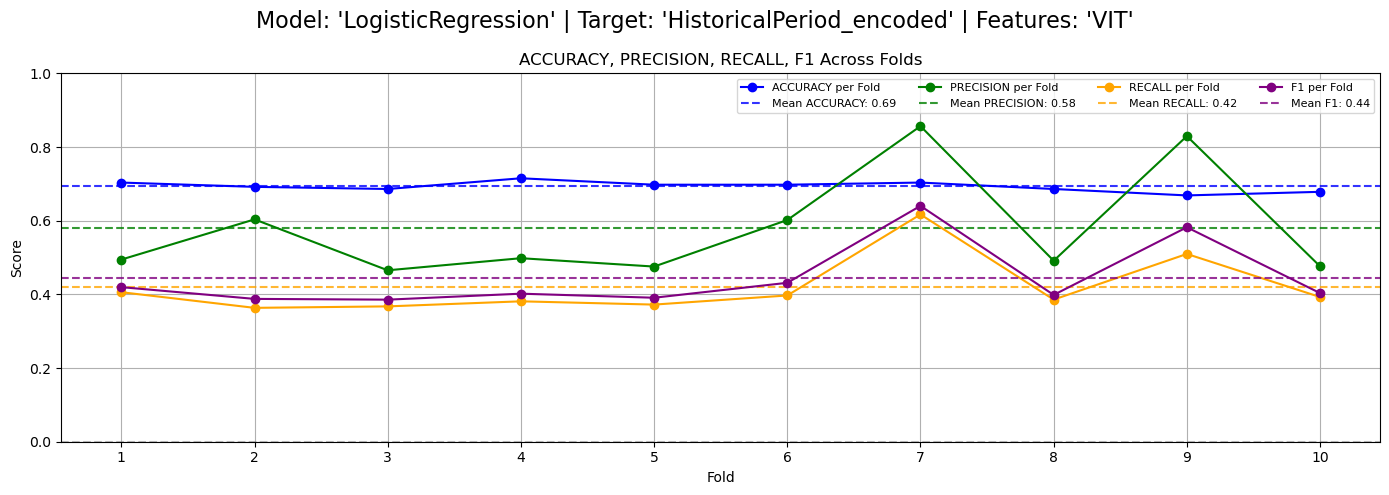

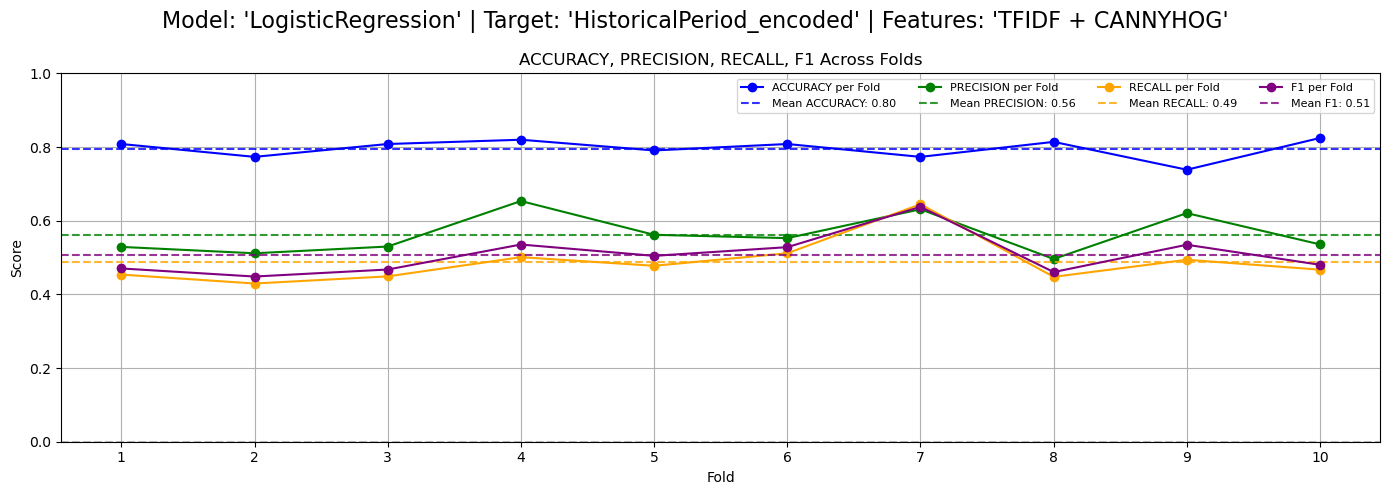

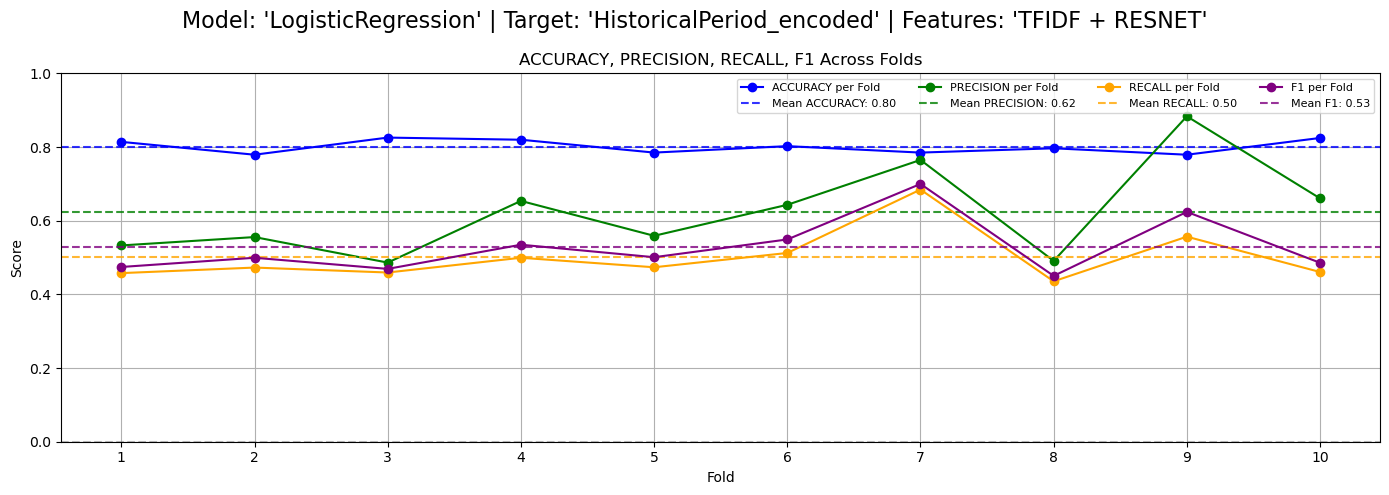

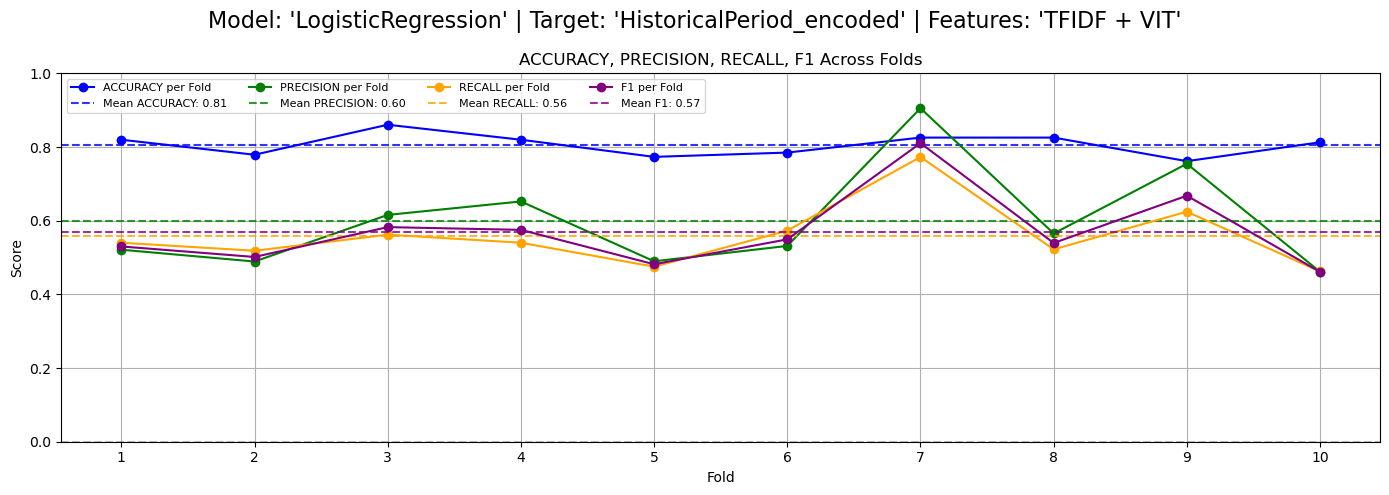

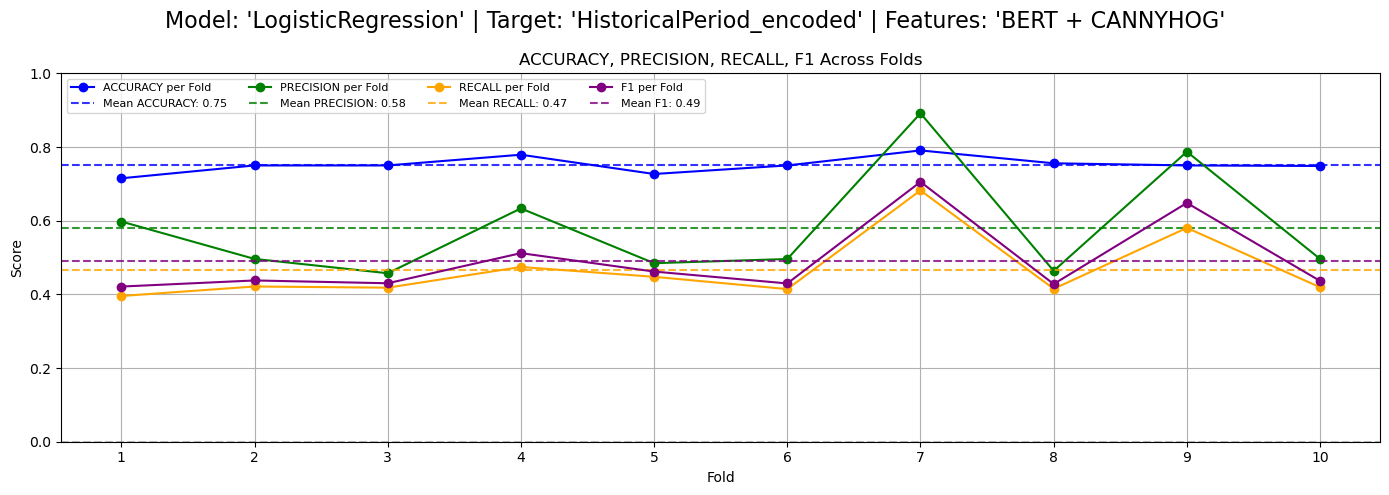

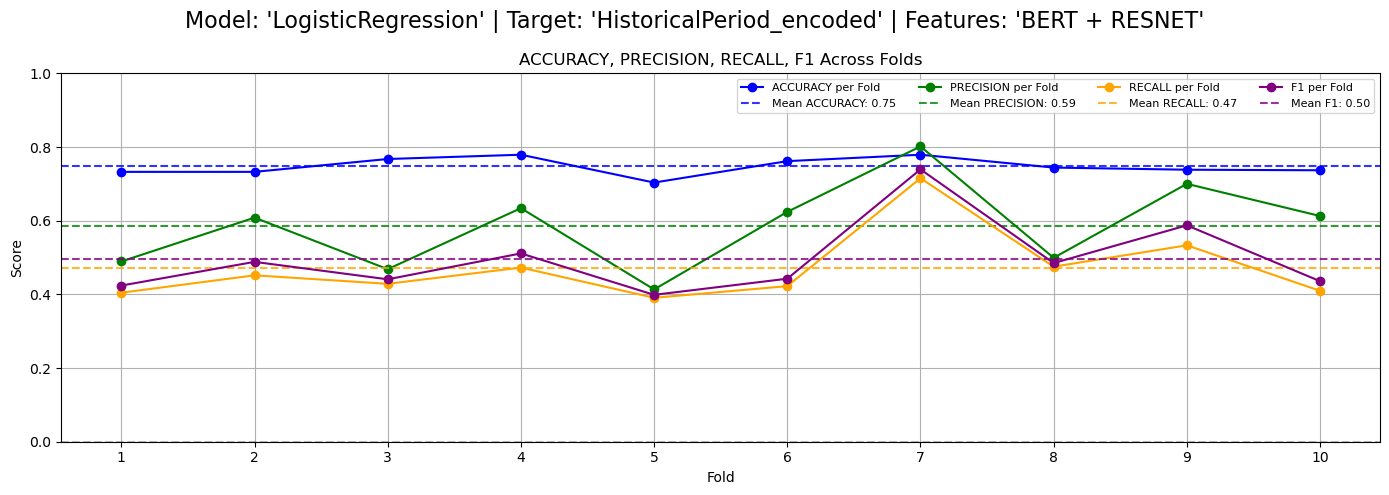

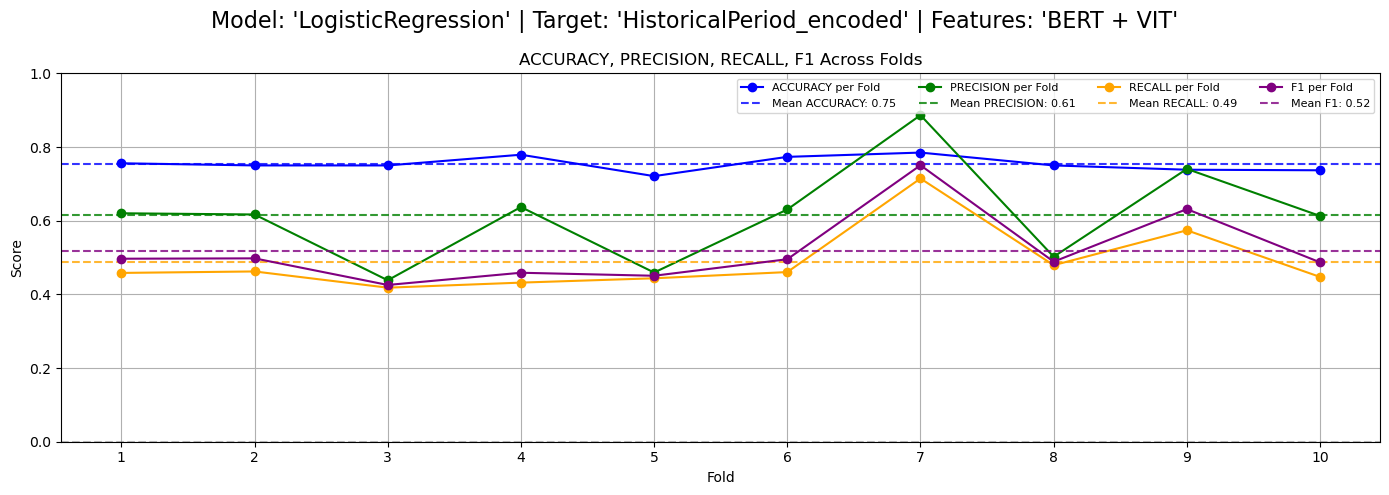

Compare Mean Cross Validation Scores of Feature Sets for One Model


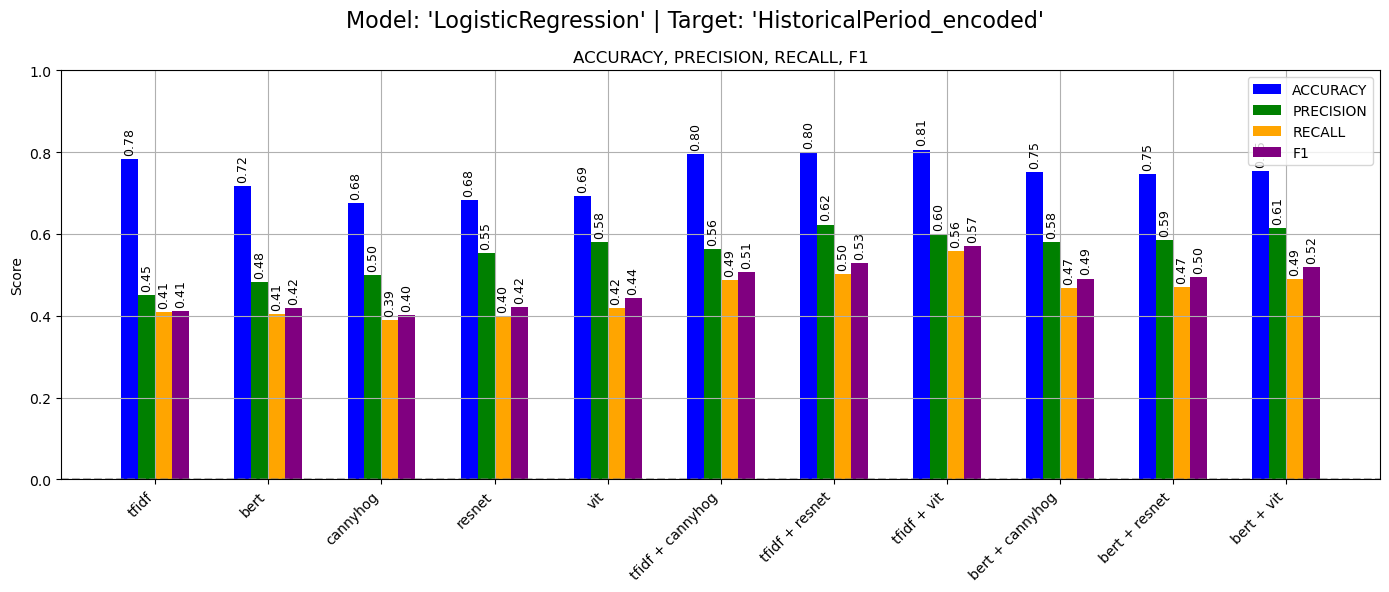

In [15]:
model_name = 'LogisticRegression'
model_class = LogisticRegression

model_scoreboard = run_cv_all(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X["train"],
    y["train"][["HistoricalPeriod_encoded"]]
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## KNN

Compare Mean Cross Validation Scores of Feature Sets for One Model


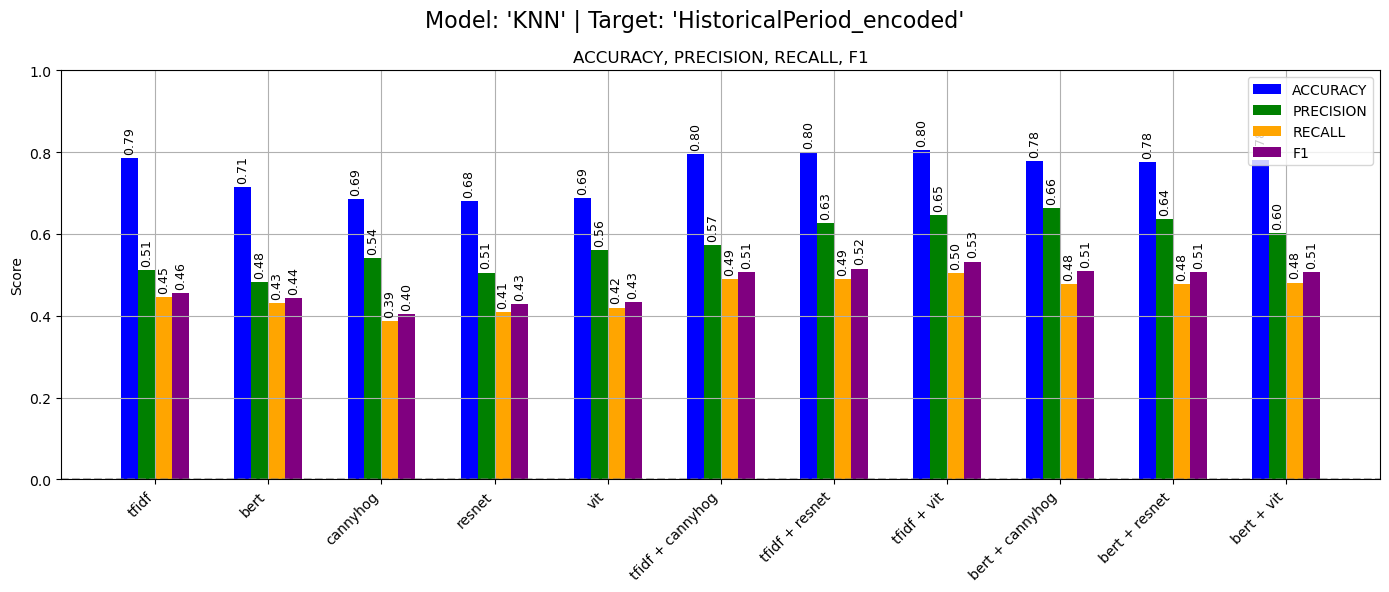

In [16]:
model_name = 'KNN'
model_class = KNeighborsClassifier

model_scoreboard = run_cv_all(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X_reduced["train"],
    y["train"][["HistoricalPeriod_encoded"]],
    enable_plots=False
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## Random Forrest

Compare Mean Cross Validation Scores of Feature Sets for One Model


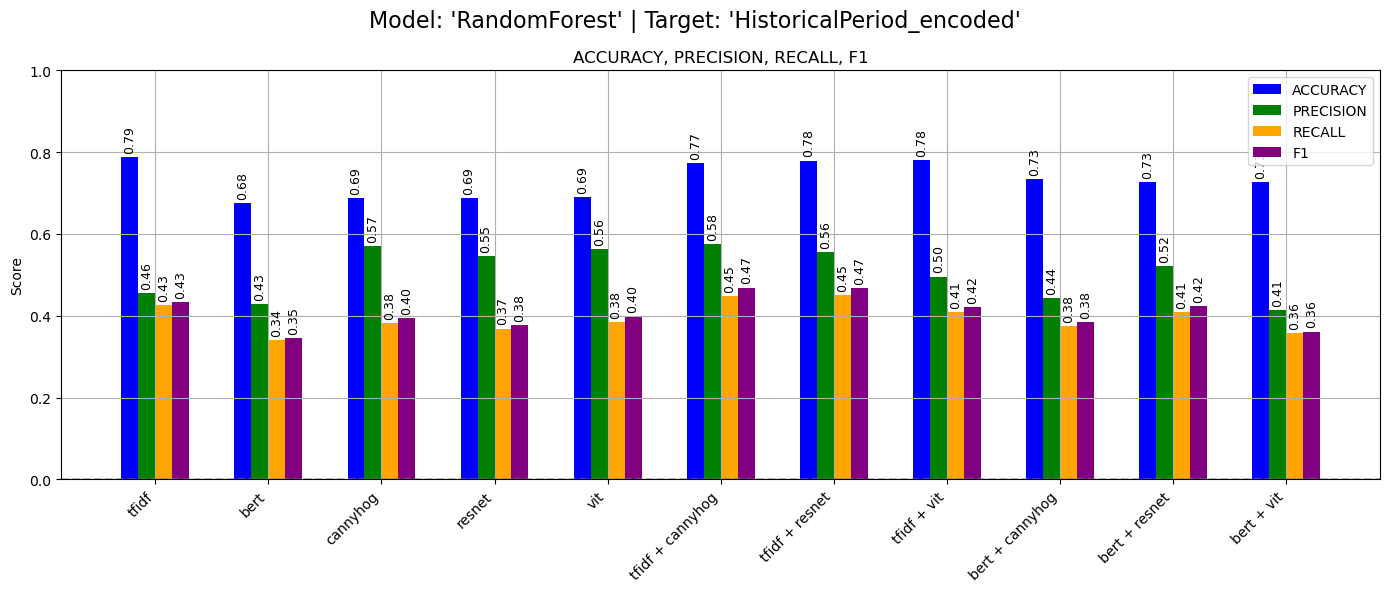

In [17]:
model_name = 'RandomForest'
model_class = RandomForestClassifier

model_scoreboard = run_cv_all(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X["train"],
    y["train"][["HistoricalPeriod_encoded"]],
    enable_plots=False
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## XGBoost

Compare Mean Cross Validation Scores of Feature Sets for One Model


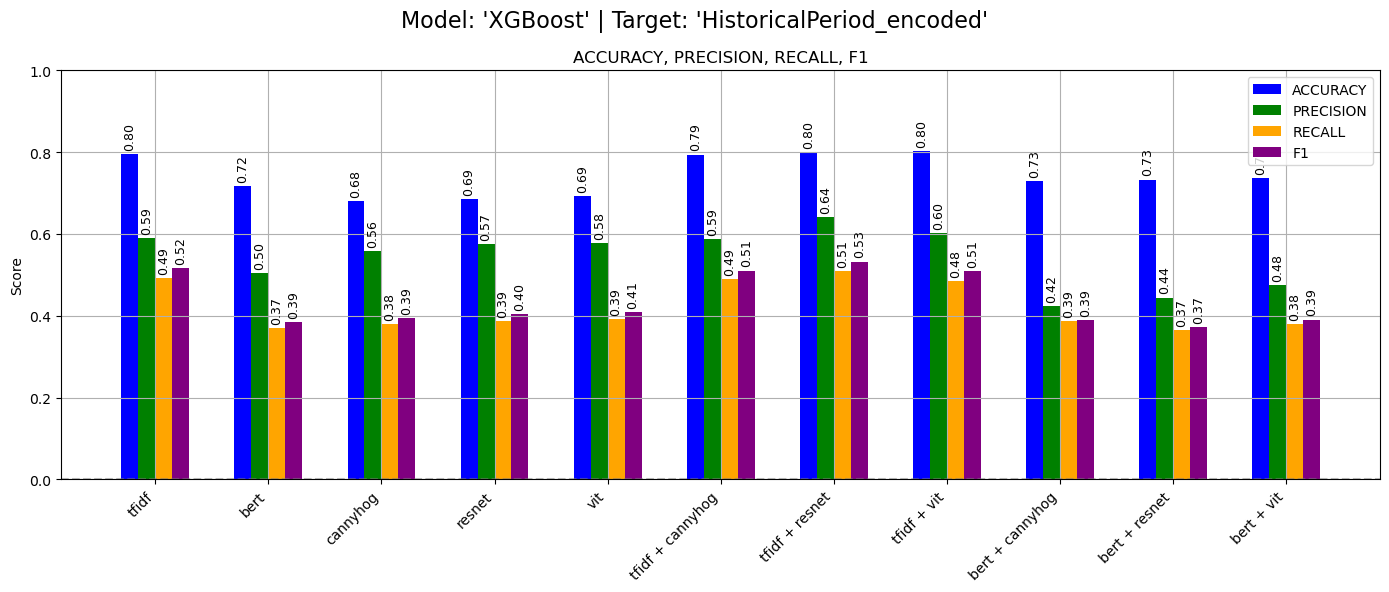

In [18]:
model_name = 'XGBoost'
model_class = XGBClassifier

model_scoreboard = run_cv_all(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X_reduced["train"],
    y["train"][["HistoricalPeriod_encoded"]],
    enable_plots=False
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## LightGBM

Compare Mean Cross Validation Scores of Feature Sets for One Model


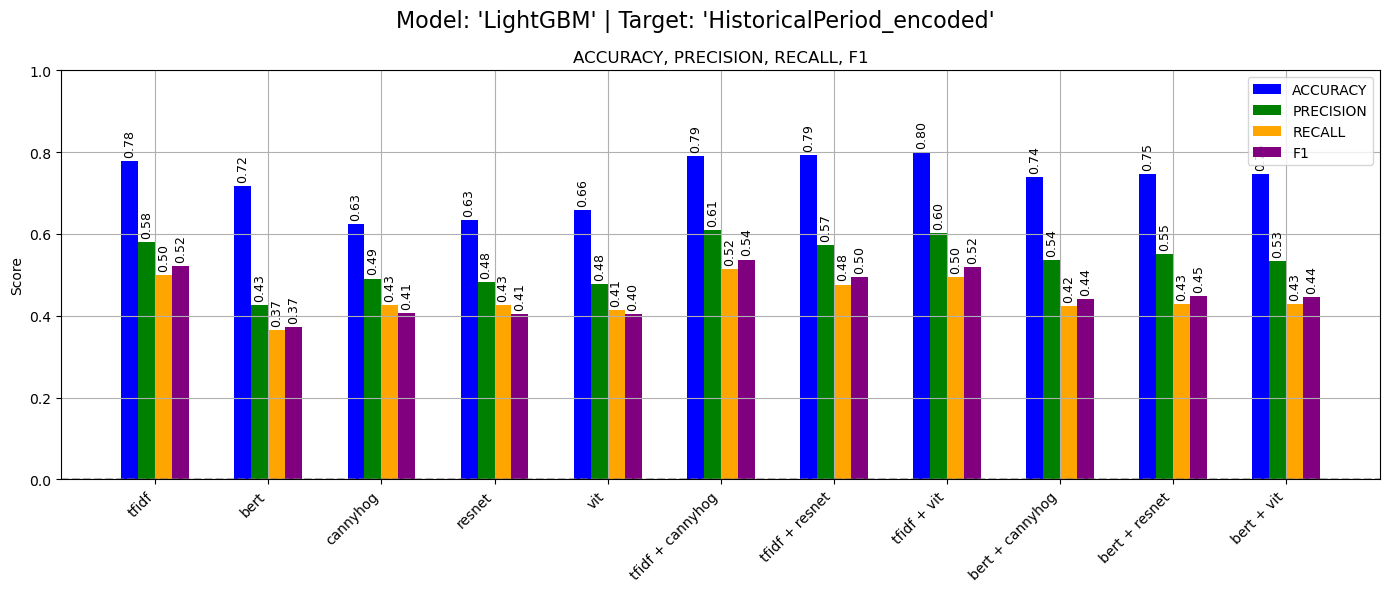

In [19]:
model_name = 'LightGBM'
model_class = LGBMClassifier

model_scoreboard = run_cv_all(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X_reduced["train"],
    y["train"][["HistoricalPeriod_encoded"]],
    enable_plots=False
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## Final Scoreboard

In [20]:
scoreboard

,model,target,features,accuracy,precision,recall,f1
0,LogisticRegression,HistoricalPeriod_encoded,tfidf,0.783602,0.451795,0.408849,0.411579
1,LogisticRegression,HistoricalPeriod_encoded,bert,0.717850,0.481629,0.405132,0.418756
2,LogisticRegression,HistoricalPeriod_encoded,cannyhog,0.676564,0.498642,0.388886,0.402898
3,LogisticRegression,HistoricalPeriod_encoded,resnet,0.683527,0.554487,0.399265,0.420627
4,LogisticRegression,HistoricalPeriod_encoded,vit,0.692836,0.579237,0.419222,0.444136
5,LogisticRegression,HistoricalPeriod_encoded,tfidf + cannyhog,0.795828,0.562105,0.487536,0.506726
6,LogisticRegression,HistoricalPeriod_encoded,tfidf + resnet,0.801061,0.623000,0.501225,0.528703
7,LogisticRegression,HistoricalPeriod_encoded,tfidf + vit,0.806287,0.598600,0.559071,0.569892
8,LogisticRegression,HistoricalPeriod_encoded,bert + cannyhog,0.751598,0.580378,0.466843,0.491072
9,LogisticRegression,HistoricalPeriod_encoded,bert + resnet,0.747521,0.585085,0.470387,0.495277


In [21]:
scoreboard.to_csv(
    "cv_scoreboard.csv",
    index=False,
    encoding='utf-8',
    sep=',',
    header=True
)